<a href="https://colab.research.google.com/github/tuanymariiah/DSB/blob/main/DSB_Processo_Seletivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processo Seletivo DSB
---
Autora: Tuany Mariah Lima do Nascimento


# Importacao das Bibliotecas
---



In [1]:
import warnings
import re
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn
import string
from matplotlib import pyplot as plt
from matplotlib import gridspec

#----

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# Carrega Dataset

Primeiramente os datasets licitacao e item, no período de 2016 a 2019 serão carregados, concatenados individualmente criando um só dataset.

---
***Obs: os datasets foram armazenados no google drive devido a limitacao de armazenamento do computador.***


In [2]:
licitacao2016 = '/content/drive/MyDrive/Projetos Pessoais/processos seletivos/DSB/datasets/2016/licitacao2016.csv'
licitacao2017 = '/content/drive/MyDrive/Projetos Pessoais/processos seletivos/DSB/datasets/2017/licitacao2017.csv'
licitacao2018 = '/content/drive/MyDrive/Projetos Pessoais/processos seletivos/DSB/datasets/2018/licitacao2018.csv'
licitacao2019 = '/content/drive/MyDrive/Projetos Pessoais/processos seletivos/DSB/datasets/2019/licitacao2019.csv'

df_licitacao2016 = pd.read_csv(licitacao2016)
df_licitacao2017 = pd.read_csv(licitacao2017)
df_licitacao2018 = pd.read_csv(licitacao2018)
df_licitacao2019 = pd.read_csv(licitacao2019)

licitacao_list = [df_licitacao2016, df_licitacao2017, df_licitacao2018, df_licitacao2019]
licitacao = pd.concat(licitacao_list)

#----------
item2016 = '/content/drive/MyDrive/Projetos Pessoais/processos seletivos/DSB/datasets/2016/item2016.csv'
item2017 = '/content/drive/MyDrive/Projetos Pessoais/processos seletivos/DSB/datasets/2017/item2017.csv'
item2018 = '/content/drive/MyDrive/Projetos Pessoais/processos seletivos/DSB/datasets/2018/item.csv'
item2019 = '/content/drive/MyDrive/Projetos Pessoais/processos seletivos/DSB/datasets/2019/item2019.csv'

df_item2016 = pd.read_csv(item2016,encoding='utf-8', header=0, sep=',', decimal=",")
df_item2017 = pd.read_csv(item2017,encoding='utf-8', header=0, sep=',', decimal=",",)
df_item2018 = pd.read_csv(item2018,encoding='utf-8', header=0, sep=',', decimal=",")
df_item2019 = pd.read_csv(item2019,encoding='utf-8', header=0, sep=',', decimal=",")
item_list = [df_item2016, df_item2017, df_item2018, df_item2019]
item = pd.concat(item_list)



Para iniciar, foi necessário realizar um filtro pela coluna TP_OBJETO, usando apenas o COM que corresponde a compras, seguido de um merge entre as duas tabelas, licitacao e item no período de 2016 a 2019.

In [3]:
licitacao_compras = licitacao[licitacao['TP_OBJETO']=='COM']
df = licitacao_compras.merge(item[['CD_ORGAO','NR_LICITACAO', 'QT_ITENS','ANO_LICITACAO', 'CD_TIPO_MODALIDADE', 'VL_UNITARIO_HOMOLOGADO','VL_TOTAL_HOMOLOGADO', 'VL_UNITARIO_ESTIMADO','VL_TOTAL_ESTIMADO','DS_ITEM']], how='inner', left_on=['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE'], right_on=['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE'])


Um outro filtro também foi feito, porém dessa vez com palavras como *serviço|servidores|contrato|contratação|anexo|locação|tabela|storage all|constituído deconforme|aquisição|edital* tudo que poderia ser ser considerado um contrato de um serviço que não é considerado um bem material.
Logo, todos os dados que possuem as palavras já mencionadas, foram excluídos do dataset.


In [4]:
df = df[~df['DS_OBJETO'].str.contains("serviço|servidores|contrato|contratação|anexo|locação|tabela|storage all|constituído deconforme|aquisição|edital",na=False, case=True)].reset_index(drop =True)
df = df[~df['DS_ITEM'].str.contains("serviço|servidores|contrato|contratação|anexo|anexos|locação|conforme anexo|tabela|storage all|constituído deconforme|aquisição|edital",na=False, case=True)].reset_index(drop =True)



números, pontuações, acentos, e stopwords foram removidos, e depois convertidos em letras minúsculas

In [5]:
#df = licitacao_compras.merge(item[['CD_ORGAO','NR_LICITACAO', 'QT_ITENS','ANO_LICITACAO', 'CD_TIPO_MODALIDADE', 'VL_UNITARIO_HOMOLOGADO','VL_TOTAL_HOMOLOGADO', 'VL_UNITARIO_ESTIMADO','VL_TOTAL_ESTIMADO','DS_ITEM']], how='inner', left_on=['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE'], right_on=['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE'])
df['DS_ITEM'] = df['DS_ITEM'].apply( lambda x: re.sub( '[0-9]|\,|\.|\%|\/|\-|[^a-zA-Z0-9 \\\]','', x ).lower())
df['DS_OBJETO'] = df['DS_OBJETO'].apply( lambda x: re.sub( '[0-9]|\,|\.|\%|\/|\-|[^a-zA-Z0-9 \\\]','', x ).lower())

In [6]:
dsitem = df['DS_ITEM']
def Preprocessing(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

dsitem = [Preprocessing(i) for i in dsitem]
df['DS_ITEM'] = dsitem


deixa registrado apenas a primeira palavra do item licitado

In [7]:
#dsitem=df['DS_ITEM]
def primeira_palavra(registro):
  try:
      registro = re.search("(\w+)", registro).group(0)
  except AttributeError:
      registro = re.search("(\w+) (\w+) (\w+)", registro)
  return registro

df['DS_ITEM']  =  df['DS_ITEM'].apply(lambda x : primeira_palavra ( x ))


verificação de valores vazios nas principais colunas a serem utilizadas

In [8]:
#verificando os valores nulos
df[['DS_ITEM', 'VL_UNITARIO_HOMOLOGADO', 'ANO_LICITACAO', 'NM_ORGAO', 'VL_UNITARIO_ESTIMADO', 'DT_ABERTURA',
    'DT_HOMOLOGACAO', 'DT_ADJUDICACAO', 'QT_ITENS']].isna().sum()

DS_ITEM                     1083
VL_UNITARIO_HOMOLOGADO    132229
ANO_LICITACAO                  0
NM_ORGAO                       0
VL_UNITARIO_ESTIMADO       18502
DT_ABERTURA                    0
DT_HOMOLOGACAO             99491
DT_ADJUDICACAO            104243
QT_ITENS                       0
dtype: int64

exclusão de dados que possuiam valores vazios nas colunas a serem utilizadas para a análise

In [9]:
df.dropna(how='any',axis=0, subset= ['DS_ITEM', 'VL_UNITARIO_HOMOLOGADO', 'ANO_LICITACAO', 'NM_ORGAO', 'VL_UNITARIO_ESTIMADO', 'DT_ABERTURA','DT_HOMOLOGACAO', 'DT_ADJUDICACAO'], inplace = True)

Uma análise descritiva da estatistica foi feita para poder ver inicialmente ver a presença de outliers, com isso, é possível ver que havia a presença de valores negativos paara a coluna *VL_UNITARIO_HOMOLOGADO* e igual a zero para a coluna *VL_UNITARIO_ESTIMADO*
com isso, foram considerados apenas os itens que possuiam valores acima de 0, para as respectivas tabelas

In [10]:
#descrricao de cada coluna do dataset
#df.describe()
df['VL_UNITARIO_ESTIMADO'] = df['VL_UNITARIO_ESTIMADO'].astype(float)
df['VL_UNITARIO_HOMOLOGADO'] = df['VL_UNITARIO_HOMOLOGADO'].astype(float)
#como podemos ver, temos os valores minimos como -1 e 0 nas respectivas colunas VL_UNITARIO_HOMOLOGADO e VL_UNITARIO_ESTIMADO, por tanto as linhas que possuir esse valor serao substituidas com a média
df[['VL_UNITARIO_HOMOLOGADO','VL_UNITARIO_ESTIMADO']].describe()

,VL_UNITARIO_HOMOLOGADO,VL_UNITARIO_ESTIMADO
count,9.885390e+05,9.885390e+05
mean,6.836577e+02,7.205713e+02
std,1.838817e+04,2.388307e+04
min,-1.932000e+04,0.000000e+00
25%,2.200000e+00,1.610000e+00
50%,6.780000e+00,6.670000e+00
75%,3.300000e+01,3.571000e+01
max,9.468921e+06,1.195005e+07


In [30]:
#retira os valores menores que 0 nos valores de VL_UNITARIO_HOMOLOGADO e VL_UNITARIO_ESTIMADO
df = df[(df['VL_UNITARIO_HOMOLOGADO']>0) & df['VL_UNITARIO_ESTIMADO']>0]

duas colunas foram criadas para poder analisar melhor este dataset, a primeira coluna foi a *VALOR_BEM* que vai rotular os dados como alto, baixo ou médio. O valor foi a ser considerado foi baseado na média 

In [31]:
#cria uma nova coluna com labels para os bens materiais 

def valorBem(registro):
  if registro['VL_UNITARIO_HOMOLOGADO'] < 8.461925e+02:
    return 'baixo'
  elif registro['VL_UNITARIO_HOMOLOGADO'] == 8.461925e+02:
    return 'medio'
  elif registro['VL_UNITARIO_HOMOLOGADO'] > 8.461925e+02:
    return 'alto'
df['VALOR_BEM'] = df.apply(valorBem, axis=1)

# Perguntas a serem respondidas


---
1. Quais itens foram comprados **acima** do valor estimado?

2. Quais itens foram comprados **abaixo** do valor estimado?

3. Quantos itens foram comprados acima, abaixo ou igual ao valor estimado?

4. Quantos itens foram comprados com valor baixo e alto

5. **Quais são os principais bens materiais comprados pelos órgãos públicos do Rio Grande do Sul?**

6. **É possível identificar algum padrão nas compras? Seja por época do ano ou por tipo de órgão comprador?**

7. Em qual ano houve mais licitação?

8. Orgao que mais fez pedido no ano de 2016

9. Orgao que mais fez pedido no ano de 2017

10. Orgao que mais fez pedido no ano de 2018

11. Orgao que mais fez pedido no ano de 2019

In [32]:
#verificando os valores nulos
df[['DS_ITEM', 'VL_UNITARIO_HOMOLOGADO', 'ANO_LICITACAO', 'NM_ORGAO', 'VL_UNITARIO_ESTIMADO', 'DT_ABERTURA',
    'DT_HOMOLOGACAO', 'DT_ADJUDICACAO', 'QT_ITENS']].isna().sum()

DS_ITEM                   0
VL_UNITARIO_HOMOLOGADO    0
ANO_LICITACAO             0
NM_ORGAO                  0
VL_UNITARIO_ESTIMADO      0
DT_ABERTURA               0
DT_HOMOLOGACAO            0
DT_ADJUDICACAO            0
QT_ITENS                  0
dtype: int64

In [33]:
def situacao_homologado(registro):
    if registro['VL_UNITARIO_HOMOLOGADO'] > registro['VL_UNITARIO_ESTIMADO']:#ACIMA DO VALOR ESTIMADO?
        return 'acima'
    elif registro['VL_UNITARIO_HOMOLOGADO'] < registro['VL_UNITARIO_ESTIMADO']:#ABAIXO DO VALOR ESTIMADO?
        return 'abaixo'
    else:
      return 'igual'#IGUAL AO VALOR ESTIMADO

df['SITUACAO'] = df.apply(situacao_homologado, axis=1)


## 1.Quais itens foram comprados acima do valor estimado?

In [34]:
df[['DS_ITEM', 'QT_ITENS', 'VL_UNITARIO_HOMOLOGADO', 'VL_UNITARIO_ESTIMADO','SITUACAO']][df['VL_UNITARIO_HOMOLOGADO']>df['VL_UNITARIO_ESTIMADO']].head(4)

,DS_ITEM,QT_ITENS,VL_UNITARIO_HOMOLOGADO,VL_UNITARIO_ESTIMADO,SITUACAO
99,toalha,10.00,6.6,6.0,acima
101,toalha,10.00,6.6,6.0,acima
107,toalha,10.00,6.6,6.0,acima
144,toalha,25.00,6.6,5.2,acima


## 2.Quais itens foram comprados abaixo do valor estimado?

In [35]:
df[['DS_ITEM', 'QT_ITENS','VL_UNITARIO_HOMOLOGADO', 'VL_UNITARIO_ESTIMADO', 'SITUACAO']][df['VL_UNITARIO_HOMOLOGADO']<df['VL_UNITARIO_ESTIMADO']].head(4)

,DS_ITEM,QT_ITENS,VL_UNITARIO_HOMOLOGADO,VL_UNITARIO_ESTIMADO,SITUACAO
0,biscoito,72.00,5.00,6.5,abaixo
1,biscoito,72.00,3.61,4.0,abaixo
2,farinha,4.00,8.58,9.0,abaixo
3,acar,4.00,12.35,16.5,abaixo


##3.Quantos itens foram comprados acima, abaixo ou igual ao valor estimado?

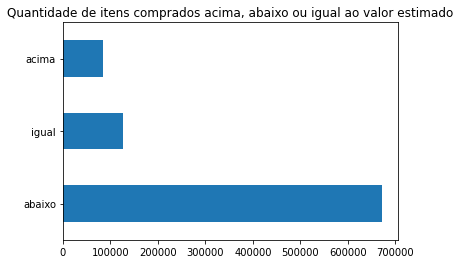

In [36]:
df['SITUACAO'].value_counts().plot(kind='barh', title='Quantidade de itens comprados acima, abaixo ou igual ao valor estimado');

## 4.Quantos itens foram comprados com valor baixo e alto

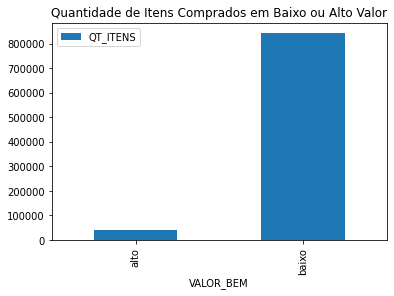

In [37]:
df[['QT_ITENS', 'VALOR_BEM']].groupby('VALOR_BEM').count().plot(kind='bar', title='Quantidade de Itens Comprados em Baixo ou Alto Valor');

## 5.Quais são os principais bens materiais comprados pelos órgãos públicos do Rio Grande do Sul?

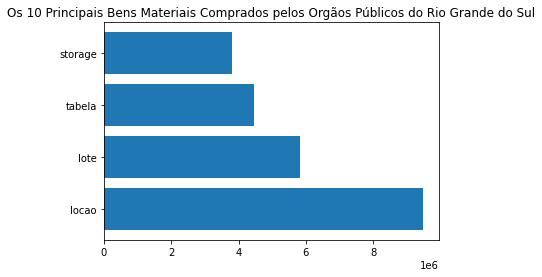

In [38]:
#procura os bens que possuem o valor alto:
#ordena pelo preco
#pega os 10primeiros
bens = df[df['VALOR_BEM']=='alto']
bens = bens[['DS_ITEM','ANO_LICITACAO','VL_UNITARIO_HOMOLOGADO', 'VALOR_BEM']].sort_values('VL_UNITARIO_HOMOLOGADO', ascending=False).head(10)
bens[['DS_ITEM', 'VL_UNITARIO_HOMOLOGADO']].value_counts()

plt.barh( bens['DS_ITEM'], bens['VL_UNITARIO_HOMOLOGADO'])
plt.title('Os 10 Principais Bens Materiais Comprados pelos Orgãos Públicos do Rio Grande do Sul');

## 6.É possível identificar algum padrão nas compras? Seja por época do ano ou por tipo de órgão comprador?


In [39]:
padrao_ano = df.groupby('ANO_LICITACAO')
padrao_ano['DS_ITEM'].value_counts()

ANO_LICITACAO  DS_ITEM    
2016           papel          2603
               pneu           2244
               luva           1791
               livro          1727
               fita           1707
                              ... 
2019           zinna             1
               zinnia            1
               ziprasidona       1
               zoe               1
               zoolgico          1
Name: DS_ITEM, Length: 32835, dtype: int64

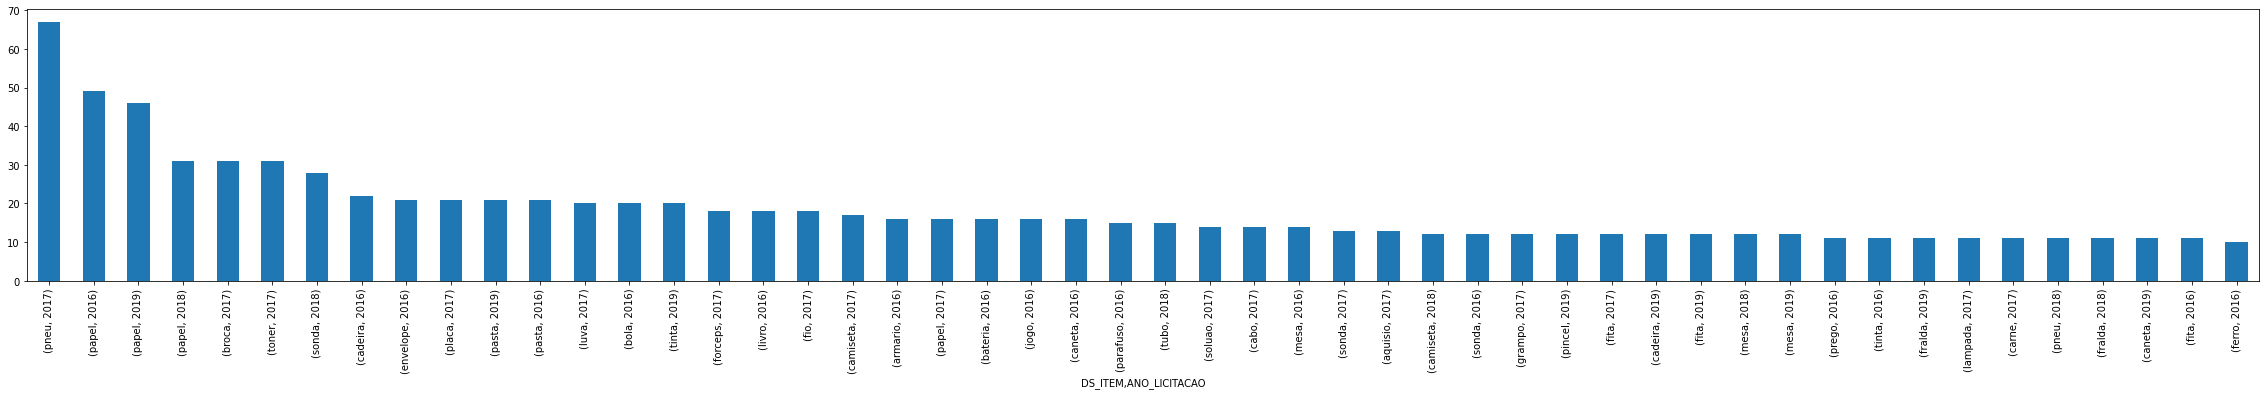

In [40]:
padrao_orgao = df[df['NM_ORGAO']=='PM DE SANTA MARIA']
padrao_orgao[['DS_ITEM', 'ANO_LICITACAO']].value_counts().head(50).plot(kind='bar', figsize=(40,5))

##7.Em qual ano houve mais licitação?

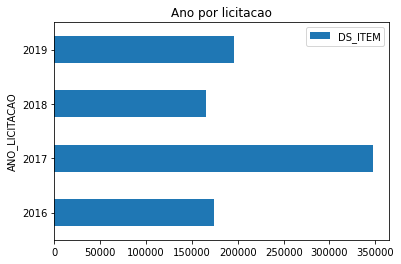

In [23]:
df[['ANO_LICITACAO', 'DS_ITEM']].groupby('ANO_LICITACAO').count().plot(kind='barh', title='Ano por licitacao');#.reset_index()


## 8.Orgao que mais fez pedido no ano de 2016

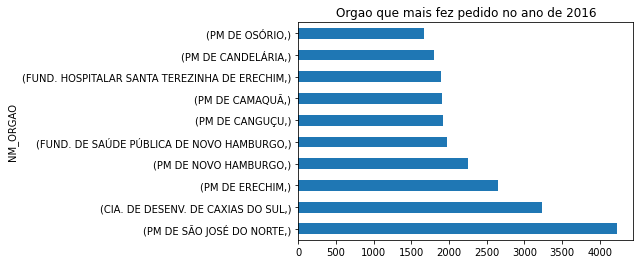

In [24]:
df[['NM_ORGAO']][df['ANO_LICITACAO']==2016].value_counts().head(10).plot(kind='barh', title='Orgao que mais fez pedido no ano de 2016');

## 9.Orgao que mais fez pedido no ano de 2017

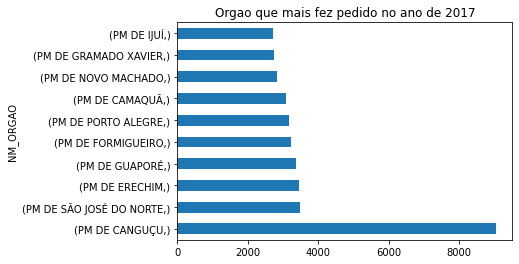

In [25]:
df[['NM_ORGAO']][df['ANO_LICITACAO']==2017].value_counts().head(10).plot(kind='barh', title='Orgao que mais fez pedido no ano de 2017');

## 10.Orgao que mais fez pedido no ano de 2018

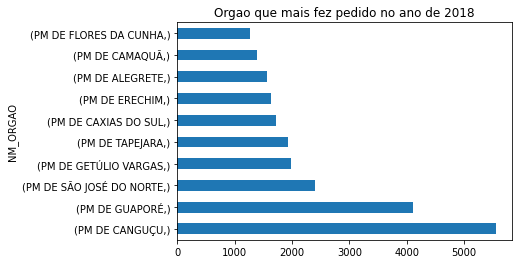

In [26]:
df[['NM_ORGAO']][df['ANO_LICITACAO']==2018].value_counts().head(10).plot(kind='barh', title='Orgao que mais fez pedido no ano de 2018');

## 11.Orgao que mais fez pedido no ano de 2019

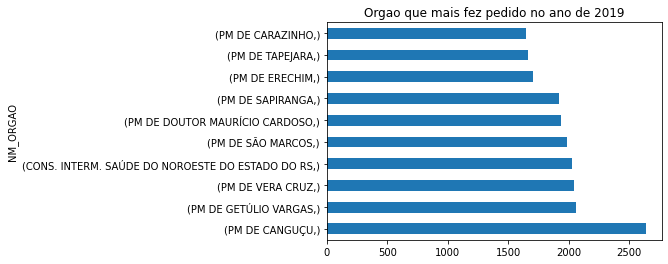

In [27]:
df[['NM_ORGAO']][df['ANO_LICITACAO']==2019].value_counts().head(10).plot(kind='barh', title='Orgao que mais fez pedido no ano de 2019');

##12.Quais os 10 primeiros orgaos que fizeram compras de materiais acima do valor estimado no período de 2016 a 2019

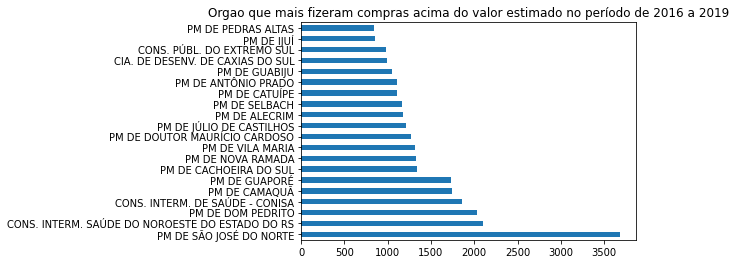

In [28]:
orgao_acima = df[df['SITUACAO']=='acima'].sort_values('VL_UNITARIO_HOMOLOGADO', ascending=False)#.value_counts().head(10)
orgao_acima['NM_ORGAO'].value_counts().head(20).plot(kind='barh', title='Orgao que mais fizeram compras acima do valor estimado no período de 2016 a 2019');